<a href="https://colab.research.google.com/github/pevu97/Jobb-Offer-Classifier/blob/main/notebook/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:

!pip install beautifulsoup4
import requests
import pandas as pd
import numpy as np
from PIL import Image
from io import BytesIO
from bs4 import BeautifulSoup

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix



def get_job_details(job_id):
  job_id = job_id
  url = f"https://nofluffjobs.com/api/posting/{job_id}"

  headers = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.5735.90 Safari/537.36",
      "Accept": "application/json"
  }

  response = requests.get(url, headers=headers)

  return response.json()


def get_job_list(sentence):
  url = "https://nofluffjobs.com/api/search/posting"
  params = {
      "pageFrom": 1,
      "pageTo": 1,
      "pageSize": 20,
      "salaryCurrency": "PLN",
      "salaryPeriod": "month",
      "region": "pl",
      "language": "pl-PL",
      "withSalaryMatch": "true"
  }

  headers = {
      "Content-Type": "application/infiniteSearch+json",
      "User-Agent": "Mozilla/5.0"
  }

  payload = {
      "rawSearch": f"requirement={sentence}"
  }

  response = requests.post(url, headers=headers, params=params, json=payload)

  return response.json()


In [2]:
offer_list = get_job_list("python")
type(offer_list)

dict

In [3]:
offer_list['postings'][55]['id']

'mid-backend-python-developer-alterdata-io-lower-silesian'

In [4]:
jobs_titles = []
for offer in offer_list['postings']:
  jobs_titles.append(offer['id'])

In [5]:
job_details = get_job_details(jobs_titles[0])

In [6]:
keywords = [
    "python", "java", "javascript", "react", "django", "sql", "node", "devops", "qa",
    "junior", "mid", "entry", "trainee", "intern"
]


title_list = []
for key in keywords:
  offer_list = get_job_list(key)['postings']
  for offer in offer_list:
    title_list.append(offer['id'])
len(title_list)

2050

In [7]:
title_list[1]

'senior-python-developer-xebia-Wrocław'

In [8]:
job_details = []

for title in title_list:
  job_details.append(get_job_details(title))


In [9]:
len(job_details)

2050

In [10]:
from collections import Counter

labels = [offer['basics']['seniority'][0].lower() for offer in job_details if offer.get('basics', {}).get('seniority')]
print(Counter(labels))

Counter({'senior': 870, 'mid': 797, 'junior': 226, 'trainee': 136, 'expert': 21})


In [11]:
jobs = {'senior':[], 'mid':[], 'junior':[]}

In [12]:
for offer in job_details:
  if offer.get('basics', {}).get('seniority'):
    if 'senior' in offer['basics']['seniority'][0].lower():
      jobs['senior'].append(offer)
    if 'mid' in offer['basics']['seniority'][0].lower():
      jobs['mid'].append(offer)
    if 'junior' in offer['basics']['seniority'][0].lower():
      jobs['junior'].append(offer)
    if 'trainee' in offer['basics']['seniority'][0].lower():
      jobs['junior'].append(offer)
    if 'expert' in offer['basics']['seniority'][0].lower():
      jobs['senior'].append(offer)

In [14]:
len(jobs['junior'])

362

In [15]:
type(jobs['senior'][0])

dict

In [30]:
jobs['junior'][0]['title']

'Junior Front-end Developer'

In [64]:



text = jobs['junior'][40]['requirements']['description']

soup = BeautifulSoup(text, 'html.parser')
clean_text = soup.get_text()
print(clean_text)

YOUR PROFILE

Bachelor's degree in Computer Science, Information Technology, or a related field, or equivalent experience.
Minimum of 3 years of experience working with ServiceNow HRSD.
ServiceNow HRSD implementer certification
Strong understanding of HR processes, such as employee lifecycle management, case management, and knowledge management.
Experience in requirements gathering, and solution design.
Excellent communication and interpersonal skills, with the ability to effectively collaborate with technical and non-technical stakeholders.



In [32]:
jobs['senior'][0]['requirements']['musts'][0]

{'value': 'Python', 'type': 'main'}

In [33]:
for key in jobs['senior'][0]['requirements']['musts'][0]:
  print(jobs['senior'][0]['requirements']['musts'][0][key])

Python
main


In [34]:
new_offers = {'senior':['senior'], 'mid':['mid' ], 'junior':[ 'junior']}

In [35]:
for offer in jobs['senior']:
  if offer['requirements']['description']:
    soup = BeautifulSoup(offer['requirements']['description'], 'html.parser')
    clean_text = soup.get_text()


In [36]:

def clean_html(html_str):
    return BeautifulSoup(html_str or "", "html.parser").get_text(separator=" ")

dataset = []

for label, offers in jobs.items():
    for offer in offers:
        title = offer.get("title", "")

        desc_html = offer.get("details", {}).get("description", "")
        req_html = offer.get("requirements", {}).get("description", "")

        musts = offer.get("requirements", {}).get("musts", [])
        nices = offer.get("requirements", {}).get("nices", [])

        must_skills = " ".join([m.get("value", "") for m in musts])
        nice_skills = " ".join([n.get("value", "") for n in nices])

        desc_text = clean_html(desc_html)
        req_text = clean_html(req_html)

        full_text = f"{title}\n{desc_text}\n{req_text}\nMust have: {must_skills}\nNice to have: {nice_skills}"

        dataset.append({
            "text": full_text,
            "label": label
        })

# Konwersja do DataFrame i zapis
df = pd.DataFrame(dataset)
df.to_csv("job_offers_dataset.csv", index=False)
print("✅ Zapisano plik job_offers_dataset.csv")


✅ Zapisano plik job_offers_dataset.csv


In [37]:
df['label'].value_counts()

,count
label,
senior,891
mid,797
junior,362


In [38]:
min_count = 362

In [39]:
senior = df[df['label'] == 'senior'].sample(n=min_count, random_state=42)
mid = df[df['label'] == 'mid'].sample(n=min_count, random_state=42)
junior = df[df['label'] == 'junior'].sample(n=min_count, random_state=42)

In [40]:
new_df = pd.concat([senior, mid, junior], ignore_index=True)


In [41]:
new_df['label'].value_counts()

,count
label,
senior,362
mid,362
junior,362


In [42]:
X = new_df['text'].values

In [43]:

le = LabelEncoder()

y = le.fit_transform(new_df['label'])

In [44]:
le.classes_

array(['junior', 'mid', 'senior'], dtype=object)

In [45]:
X[0]

'Business Consultant\nPosition overview:  We are looking for a Business Consultant to support the development of accounting and financial systems for a Dutch client. The consultant will be responsible for analyzing financial and accounting requirements, translating them into functional specifications and documentation that supports development and business goals. \n \n What we offer: \n 💰 Attractive remuneration: B2B 18 000 – 22 000 PLN/month net (includes 26 days of paid days off) \n 🏡 100% remote work opportunity available \n 🌱 We care about our employees’ development and stability \n 🌍 Work in an international environment \n 🎓 International training and certifications (e.g., Microsoft MCP) \n 🚀 Continuous personal growth: defined career paths, additional training leave, and training budget \n 🏥 Medical package, Multisport card, life insurance, and language courses \n 🏢 Modern office \n 💡 Knowledge sharing sessions: e.g., Agile Coffee/Agile Knowledge Sharing, Tech-Zone, Chillout Zone

In [46]:
y[:4]

array([2, 2, 2, 2])

In [47]:
len(X)

1086

In [48]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
len(X_train)

868

In [51]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_test)

In [52]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [53]:
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=200)

In [54]:
X_train_pad[1].shape

(200,)

In [67]:
X_test_pad[0].shape

(200,)

In [71]:
y_test[0]

np.int64(1)

In [58]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

callback = EarlyStopping(monitor='val_loss', patience=5)

In [61]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 100))
model.add(Conv1D(filters = 8, kernel_size=2, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units = 3, activation='softmax'))

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(200, None))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (200, None, 100)       │       539,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (200, None, 8)         │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (200, None, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (200, 8)               │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (200, 16)              │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (200, 16)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (200, 3)               │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 540,903 (2.06 MB)

 Trainable params: 540,903 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history = model.fit(X_train_pad, y_train, epochs= 40, batch_size=10, validation_split=0.2, callbacks = [callback])

Epoch 1/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3577 - loss: 1.2008 - val_accuracy: 0.6264 - val_loss: 1.1477
Epoch 2/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4052 - loss: 1.1316 - val_accuracy: 0.8103 - val_loss: 1.0557
Epoch 3/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5408 - loss: 1.0126 - val_accuracy: 0.8506 - val_loss: 0.8898
Epoch 4/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6360 - loss: 0.8135 - val_accuracy: 0.8851 - val_loss: 0.6839
Epoch 5/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7795 - loss: 0.6002 - val_accuracy: 0.9310 - val_loss: 0.5076
Epoch 6/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8153 - loss: 0.4652 - val_accuracy: 0.9540 - val_loss: 0.3814
Epoch 7/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8844 - loss: 0.4076 - val_accuracy: 0.9713 - val_loss: 0.3125
Epoch 8/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8681 - loss: 0.3564 - val_accuracy: 0.9713 - val_loss

In [63]:


def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Accuracy
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig1.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig1.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy',
                      xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')

    fig1.show()

    # Loss
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig2.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig2.update_layout(width=1000, height=500, title='Loss vs. Val Loss',
                      xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig2.show()

plot_hist(history)


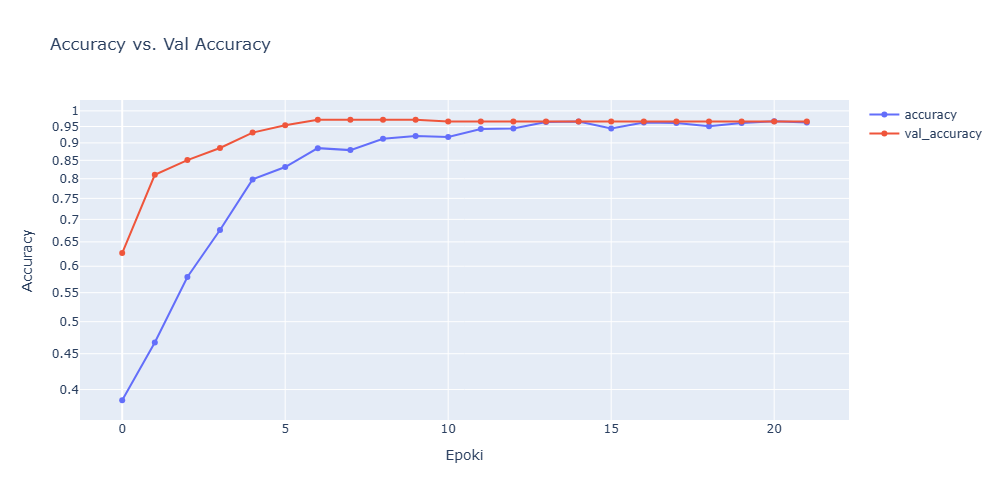

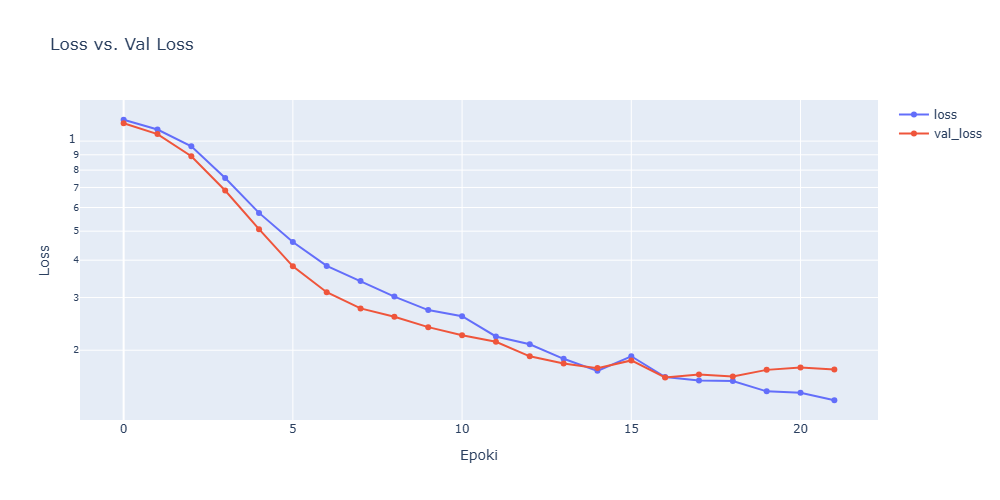

In [101]:

url1 = 'https://kocotmeble.com/wp-content/uploads/2025/07/newplot-2.png'
url2 = 'https://kocotmeble.com/wp-content/uploads/2025/07/newplot-3.png'


response = requests.get(url1)
img = Image.open(BytesIO(response.content))
display(img)


response = requests.get(url2)
img = Image.open(BytesIO(response.content))
display(img)

In [75]:
predict = model.predict(X_test_pad)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [76]:
y_pred = predict.argmax(axis=1)
predict_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
predict_df.head()

,y_true,y_pred
0,1,1
1,2,2
2,0,0
3,0,0
4,1,1


In [78]:


cm = confusion_matrix(y_test, y_pred)
cm

array([[65,  1,  3],
       [ 0, 69,  2],
       [ 0,  0, 78]])

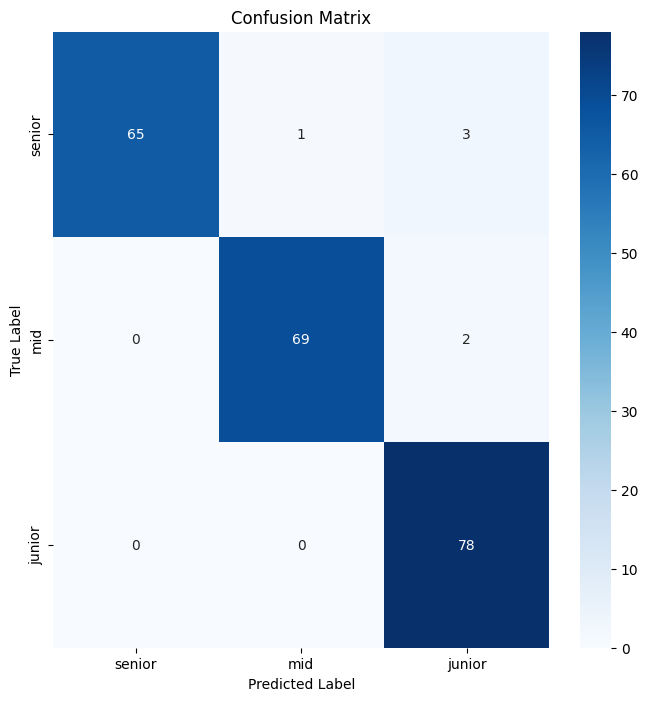

In [92]:
labels = ['senior', 'mid', 'junior']

def plot_confusion_matrix(cm):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm)

In [93]:
accuracy = np.mean(y_pred == y_test)
print(f"Dokładność: {accuracy * 100:.2f}")

Dokładność: 97.25


In [94]:
model.save('job_offer_classifier.keras')